# Generative Adversarial Networks
An alternative to Variational Autoencoders for learning a latent space, would be generative adversarial networks (GANs).
GANs function by training a generator network, and a discriminator in tandem. The generator is a decoder responsible for sampling the assumed latent space to output synthetic examples, such as an image. The discriminator is responsible for distinguishing the synthetic examples from the real ones. Feedback from the discriminator is then relayed back to the generator to enable it to produce even more realistic fake examples. This feedback loop allows the generator to consistently improve until the discriminator is incapable of identifying which examples are fake.

In this notebook, the GAN implementation will be trained on images from the CIFAR10 data. Only images of frogs will be used for ease of implementation.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
## GAN GENERATOR NETWORK
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = tf.keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

In [3]:
## GAN DISCRIMINATOR NETWORK

#candidate img input
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x) # Classification

discriminator = models.Model(discriminator_input, x)

discriminator_optimizer = tf.keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8
)

discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

In [4]:
## ADVERSARIAL NETWORK - link generator & discriminator

discriminator.trainable = False  #Freeze discriminator weights for gan model

gan_input = tf.keras.Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)

gan_optimizer = tf.keras.optimizers.RMSprop(
    lr=0.0004,
    clipvalue=1.0,
    decay=1e-8
)

gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### GAN Training
To train the GAN the following steps are performed for each epoch:
1. Draw random points from the latent space
2. Generate images with sampled points
3. Mix generated images with real images
4. Train disciminator with mixed images using "real"/"fake" labels
5. Draw new random points from latent space
6. Train the GAN with the random vectors, with the targets all labelled "real". This updates the generator's weights to fool the discriminator since the latter's weights are frozen in the GAN.

In [6]:
## GAN TRAINING IMPLMENTATION

(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]   #Index frog imgs
x_train = x_train.reshape((x_train.shape[0],)+(height, width, channels)).astype('float32') / 255.  #Normalize

iterations = 10000
batch_size = 20
save_dir = os.path.join(os.getcwd(), 'gan_frogs')

start = 0
for step in range(iterations):
    # Sample random points in latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # Decode to fake images
    generated_images = generator.predict(random_latent_vectors)
    
    
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images]) # Mix in real images
    
    # Label real/fake
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape) #trick - add noise
    
    d_loss = discriminator.train_on_batch(combined_images, labels) # Train discriminator
    
    # Resample random pts
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    misleading_targets = np.zeros((batch_size, 1)) #misclassify all targets as "real"
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets) #Update generator weights
    
    start += batch_size
    if start > len(x_train)-batch_size:
        start = 0
    
    # Save weights / images every couple steps
    if step % 500 == 0:
        gan.save_weights(os.path.join(save_dir, 'gan.h5'))
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        img = preprocessing.image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,
                             'gen_frog' + str(step) + '.png'))
        img = preprocessing.image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,
                             'real_frog' + str(step) + '.png'))

discriminator loss: 0.6942929
adversarial loss: 0.682448
discriminator loss: 0.69832784
adversarial loss: 0.7203633
discriminator loss: 0.7224205
adversarial loss: 0.7561606
discriminator loss: 0.69534034
adversarial loss: 0.7405336
discriminator loss: 0.7025256
adversarial loss: 0.73221695
discriminator loss: 0.6849333
adversarial loss: 0.7257632
discriminator loss: 0.70428115
adversarial loss: 0.7379888
discriminator loss: 0.6958636
adversarial loss: 0.7422268
discriminator loss: 0.6987665
adversarial loss: 0.7645606
discriminator loss: 0.7424867
adversarial loss: 0.7566115
discriminator loss: 0.68587464
adversarial loss: 0.7521839
discriminator loss: 0.67794186
adversarial loss: 0.79217035
discriminator loss: 0.7059496
adversarial loss: 0.80646086
discriminator loss: 0.6936594
adversarial loss: 0.82895553
discriminator loss: 0.69888705
adversarial loss: 0.8610897
discriminator loss: 0.645271
adversarial loss: 0.81317884
discriminator loss: 0.65794003
adversarial loss: 0.760661
discr

After training our GAN we can sample random points from the latent space to have our generator create fake frog images.

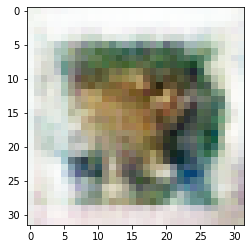

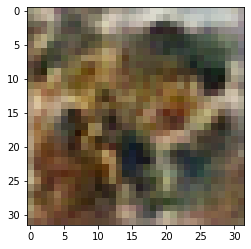

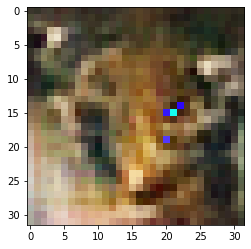

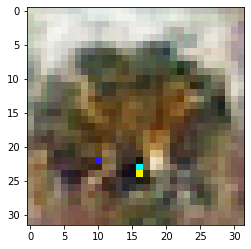

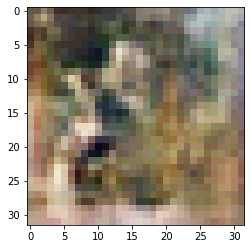

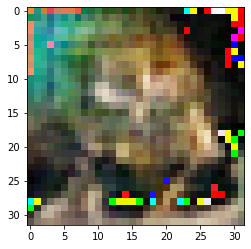

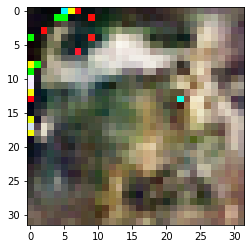

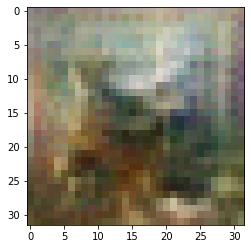

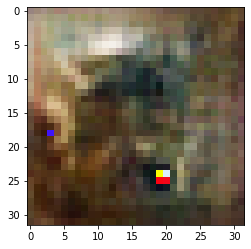

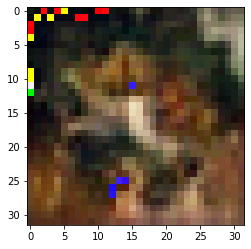

In [8]:
# Sample random points
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode to fake images
generated_images = generator.predict(random_latent_vectors)

# Plot decoded images
for i in range(generated_images.shape[0]):
    img = preprocessing.image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()